In [9]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (17, 7)

import patsy
import statsmodels.api as sm

## Loading in data

In [2]:
df = pd.read_excel('/Users/macbookpro/Documents/GitHub/Group019_WI24/data/tech_layoffs.xlsx')
df.head()

,#,Company,Location_HQ,Country,Continent,Laid_Off,Date_layoffs,Percentage,Company_Size_before_Layoffs,Company_Size_after_layoffs,Industry,Stage,Money_Raised_in_$_mil,Year,lat,lng
0,3,ShareChat,Bengaluru,India,Asia,200,2023-12-20,15.0,1333,1133,Consumer,Series H,$1700,2023,12.97194,77.59369
1,4,InSightec,Haifa,Israel,Asia,100,2023-12-19,20.0,500,400,Healthcare,Unknown,$733,2023,32.81841,34.98850
2,6,Enphase Energy,San Francisco Bay Area,USA,North America,350,2023-12-18,10.0,3500,3150,Energy,Post-IPO,$116,2023,37.54827,-121.98857
3,7,Udaan,Bengaluru,India,Asia,100,2023-12-18,10.0,1000,900,Retail,Unknown,1500,2023,12.97194,77.59369
4,14,Cruise,San Francisco Bay Area,USA,North America,900,2023-12-14,24.0,3750,2850,Transportation,Acquired,$15000,2023,37.77493,-122.41942


## Correcting data types

In order to prepare the data for exploratory analysis, we are going to correct the datatypes such that they are easily usable by plotting functions.

In [3]:
df.dtypes

#                                       int64
Company                                object
Location_HQ                            object
Country                                object
Continent                              object
Laid_Off                                int64
Date_layoffs                   datetime64[ns]
Percentage                            float64
Company_Size_before_Layoffs             int64
Company_Size_after_layoffs              int64
Industry                               object
Stage                                  object
Money_Raised_in_$_mil                  object
Year                                    int64
lat                                   float64
lng                                   float64
dtype: object

In [4]:
df['Funding'] = df['Money_Raised_in_$_mil'].apply(lambda s: np.float64(s[1:])) 
df['Funding'].head()

0     1700.0
1      733.0
2      116.0
3      500.0
4    15000.0
Name: Funding, dtype: float64

In [5]:
outcome, predictors = patsy.dmatrices('Laid_Off ~ Company_Size_before_Layoffs', df)
model = sm.OLS(outcome, predictors)
results = model.fit()
print(results.summary())


                            OLS Regression Results                            
Dep. Variable:               Laid_Off   R-squared:                       0.482
Model:                            OLS   Adj. R-squared:                  0.482
Method:                 Least Squares   F-statistic:                     1318.
Date:                Sun, 25 Feb 2024   Prob (F-statistic):          1.59e-204
Time:                        17:12:42   Log-Likelihood:                -11155.
No. Observations:                1418   AIC:                         2.231e+04
Df Residuals:                    1416   BIC:                         2.232e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

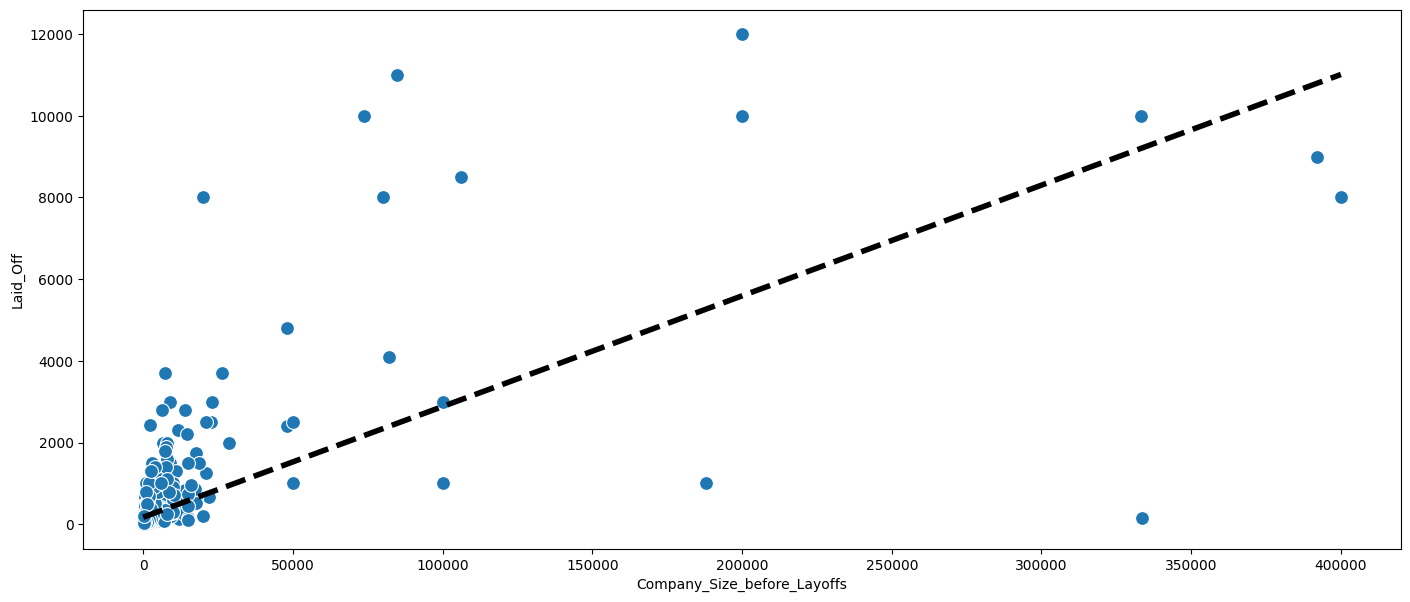

In [10]:
# Plotting scatterplot comparing Company_Size_before_Layoffs and Laid_Off 
sns.scatterplot(x='Company_Size_before_Layoffs', y='Laid_Off', data=df, s=100);

# Plotting line of best fit
xs = np.arange(df['Company_Size_before_Layoffs'].min(), df['Company_Size_before_Layoffs'].max())
ys = 0.0271 * xs + 171.0090
plt.plot(xs, ys, '--k', linewidth=4, label='Model')

In [7]:
#Demonstrates correlation between different variables 
df.corr(numeric_only=True)

,#,Laid_Off,Percentage,Company_Size_before_Layoffs,Company_Size_after_layoffs,Year,lat,lng,Funding
#,1.000000,-0.062037,0.129214,-0.048502,-0.047344,-0.825867,0.011037,-0.055777,0.008259
Laid_Off,-0.062037,1.000000,-0.039667,0.694295,0.673233,0.070815,0.047934,-0.052649,0.133239
Percentage,0.129214,-0.039667,1.000000,-0.110175,-0.111606,-0.148262,-0.035883,0.097070,-0.066364
Company_Size_before_Layoffs,-0.048502,0.694295,-0.110175,1.000000,0.999583,0.075515,0.051019,-0.064569,0.050183
Company_Size_after_layoffs,-0.047344,0.673233,-0.111606,0.999583,1.000000,0.074746,0.050496,-0.064229,0.046215
Year,-0.825867,0.070815,-0.148262,0.075515,0.074746,1.000000,-0.007747,0.067282,0.004343
lat,0.011037,0.047934,-0.035883,0.051019,0.050496,-0.007747,1.000000,-0.472637,0.010242
lng,-0.055777,-0.052649,0.097070,-0.064569,-0.064229,0.067282,-0.472637,1.000000,-0.039077
Funding,0.008259,0.133239,-0.066364,0.050183,0.046215,0.004343,0.010242,-0.039077,1.000000


In [8]:
#Pearson's correlation coefficient for Company_Size_before_Layoffs and Laid_Off
r = 0.694295 

Based on this Pearson correlation coefficient, there is a positive moderate correlation between Company_Size_before_Layoffs and Laid_Off.